# UM Ancillary Check

This notebook will read all anciliary files in your ~/cylc-run/experiment-id/share/data/ancils directory. 

It will plot the ancils so you can check that they are in the correct locations.

It will then search for any NaN points over land.

In [5]:
from pathlib import Path
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import xarray as xr
import iris
import iris.plot
import numpy as np
import os
import textwrap
import itertools
#import ants
import warnings

In [6]:
home_dir=os.environ['HOME']
HOME=Path(home_dir)

In [7]:
# Find all regions for a given rose-id
ROSE ='u-bu503'
REGION_DIRS = [ d for d in list((HOME / 'cylc-run' / ROSE / 'share/data/ancils/' ).glob('*')) if d.is_dir() ]
REGION_DIRS                                                           

[PosixPath('/home/548/pag548/cylc-run/u-bu503/share/data/ancils/Lismore')]

In [8]:
# Find all resolutions for a given REGION
for r_dir in REGION_DIRS:
    RESOLUTION_DIRS = [ d for d in list((r_dir).glob('*')) if d.is_dir() ]

In [9]:
RESOLUTION_DIRS

[PosixPath('/home/548/pag548/cylc-run/u-bu503/share/data/ancils/Lismore/era5'),
 PosixPath('/home/548/pag548/cylc-run/u-bu503/share/data/ancils/Lismore/d1100'),
 PosixPath('/home/548/pag548/cylc-run/u-bu503/share/data/ancils/Lismore/d0198')]

Quick check - can the notebook read these directories? If not, you'll need to add the gdata/project-id to the ARE storage flags and start your session again


In [10]:
!ls -lt {RESOLUTION_DIRS[0]}

total 31129264
-rw-r--r-- 1 pag548 gb02       3311 Jan 29 14:40 ancil_filenames
-rw-r--r-- 1 pag548 gb02       2838 Jan 29 14:40 ancil_versions
drwxr-sr-x 2 pag548 gb02       4096 Jan 29 14:39 orog_srtm
lrwxrwxrwx 1 pag548 gb02         32 Jan 29 14:39 qrparm.orog.mn -> orog_srtm/qrparm.orog.srtm.121x1
-rw-r--r-- 1 pag548 gb02   20119552 Jan 29 14:36 qrparm.soil.dust
-rw-r--r-- 1 pag548 gb02   28966912 Jan 29 14:35 qrparm.soil_cci
-rw-r--r-- 1 pag548 gb02   63750144 Jan 29 14:28 qrclim.smow
-rw-r--r-- 1 pag548 gb02   31883264 Jan 29 14:28 qrclim.seaice
-rw-r--r-- 1 pag548 gb02   10633216 Jan 29 14:28 qrclim.sst
-rw-r--r-- 1 pag548 gb02    9748480 Jan 29 14:27 qrparm.soil
-rw-r--r-- 1 pag548 gb02    7979008 Jan 29 14:27 qrparm.soil.dust_igbp
-rw-r--r-- 1 pag548 gb02     901120 Jan 29 14:27 qrparm.veg.dist
-rw-r--r-- 1 pag548 gb02  106233856 Jan 29 14:27 qrparm.veg.func_igbp
-rw-r--r-- 1 pag548 gb02    7979008 Jan 29 14:27 qrparm.veg.frac_igbp
-rw-r--r-- 1 pag548 gb02 8922333184 Jan 29 14

Ok if you can see a list of ancillary files whose dates match your last ancillary creation, we can continue.

To start, let's just plot and store the land-sea masks for each resolution.

Plotting land_binary_mask for era5


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


Plotting land_binary_mask for d1100
Plotting land_binary_mask for d0198


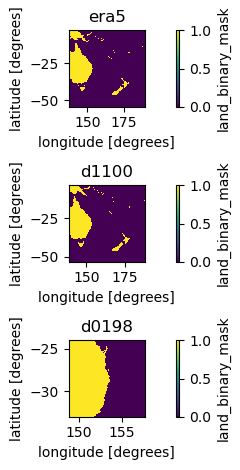

In [11]:
warnings.filterwarnings('ignore',module='mule') 
warnings.filterwarnings('ignore',module='iris') 

num_plots = len(RESOLUTION_DIRS)
lsm_masks = {}

fig,ax = plt.subplots(num_plots,1)

for i,R in enumerate(RESOLUTION_DIRS):
    MASK_FILE = R / 'qrparm.mask'
    #mask_cubes = ants.load(MASK_FILE)
    mask_cubes = iris.load(MASK_FILE)

    # Select the cube corresponding to 'land_binary_mask'
    lbm_cube, = [ cube for cube in mask_cubes if cube.name() == 'land_binary_mask'] 
    print (f'Plotting land_binary_mask for {R.name}')

    da = xr.DataArray.from_iris(lbm_cube)
    da.plot(ax=ax[i])
    ax[i].set_title(f'{R.name}')
    ax[i].set_aspect('equal')
    
    # Store the masks for later analysis
    lsm_masks[R.name] = xr.DataArray.from_iris(lbm_cube)

plt.tight_layout()

Now we create dictionaries to store all ancillary parameter files for each resolution

In [12]:
parm_files = {}

for i,R in enumerate(RESOLUTION_DIRS):
    
    all_files = list(R.glob('qrparm*'))

    # Filter out symlinks
    files = []
    [ files.append(f) for f in all_files if not f.is_symlink() ]

    parm_files[R.name] = files

Let's count how many ancillary fields we can load for each resolution

In [13]:
num_plots = {}

# Loop over LAM resolutions
for res in parm_files.keys():

    count = 0
    # Loop over each ancillary parameter file for this resolution
    for file in parm_files[res]:
        #print (f'INFO : Loading {file}')
        try:
            #cube = ants.load(file)
            cube = iris.load(file)
            #print (cube)
            count += len(cube)
        except:
            print (f'ERROR : Unable to open {file}\nERROR : You will have to manually check this file using "xconv" ')
            continue

    num_plots[res] = count
    print (f'There are {num_plots[res]} fields for {res}')
    

ERROR : Unable to open /home/548/pag548/cylc-run/u-bu503/share/data/ancils/Lismore/era5/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for era5
ERROR : Unable to open /home/548/pag548/cylc-run/u-bu503/share/data/ancils/Lismore/d1100/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for d1100
ERROR : Unable to open /home/548/pag548/cylc-run/u-bu503/share/data/ancils/Lismore/d0198/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for d0198


Here is a function to collapse multi-level cubes for simple plotting. It is assumed that any gross
errors in the ancillaries (e.g. NaNs) will remain after the averaging

In [14]:
def collapse_cube(file,
                  cube):
    """
    Collapse a cube onto lat/lon dimensions via averaging
    """
    collapse_dims = []
    
    for coord in cube.coords():
        if coord not in cube.dim_coords:
            collapse_dims.append(coord.name())
            print (f'For {file.name} {cube.name()} coordinate {coord.name()} will be collapsed')

    # We will need to collapse pseudo_level if it exists
    if 'pseudo_level' in [ c.name() for c in cube.dim_coords ]: 
        collapse_dims.append('pseudo_level')
        print (f'For {file.name} variable {cube.name()} coordinate pseudo_level will be collapsed')
            
    # Check if time remains
    if 'time' in [ c.name() for c in cube.dim_coords ]: 
        collapse_dims.append('time')
        print (f'For {file.name} variable {cube.name()} coordinate time will be collapsed')
    new_cube = cube.collapsed(collapse_dims,iris.analysis.MEAN)

    return new_cube

Let's specify what ancillaries have a land-sea mask (i.e. ocean regions are already full of NaNs)

In [15]:
land_file_types = ['soil', 'veg', 'hydtop','MORUSES' ] 

And now we define a function that will plot each ancillary for each resolution

In [16]:
def plot_ancils(region,
                files,
                num_plots,
                plot=True,
                num_columns=4,
                lat_range=[],
                lon_range=[],
                ):
    """
    Plot ancillaries fields for a given LAM resolution
    Check for the existence of NaNs and return these fields as a list
    of data_arrays
    """

    nan_fields = []
    
    num_rows = num_plots // num_columns
    
    if num_plots % num_columns != 0:
        num_rows += 1
    
    Position = range(1,num_plots+1)
    
    fig_height = num_rows*3
    fig_width = 15
    max_label_length=30

    print (f' Plotting ancillary parameters for {region}\n')
    
    fig = plt.figure(figsize=(fig_width,fig_height))
    k = 0
    
    # Loop over all ancillary files
    
    for file in files:
        try:
            #cubes = ants.load(file)
            print (f'INFO : Loading {file.name}') 
            cubes = iris.load(file)
        except:
            print (f'ERROR : Unable to open {file}')
            continue
    
        # Loop over all variables in cube
        for cube in cubes:
            ax = fig.add_subplot(num_rows, num_columns, Position[k])
    
            if len(cube.shape) > 2: 
                # Need to reduce dimension
                cube = collapse_cube(file,cube)
                
            da = xr.DataArray.from_iris(cube)
    
            # Find NaNs
            all_mask = da.isnull()
            
            # Check if this ancillary already has a land-sea mask
            if any(t in str(file) for t in land_file_types):
                # Remove the ocean from the NaN search
                all_mask = lsm_masks[region] & da.isnull()
        
            if all_mask.compute().sum() > 0:   
                print (f'ERROR : NaNs identified in {cube.name()},{file.name}')
                nan_fields.append(da)
            
            if 'standard_name' in da.attrs.keys():
                split = textwrap.wrap(da.attrs['standard_name'].replace('_',' '),max_label_length)
                label = '\n'.join(split)
                cb_args = {'label': label}
            else:
                cb_args = {'label':da.attrs['STASH']}

            # Plot according to specified lat/lon ranges
            if lat_range and lon_range:
                da.sel(latitude=slice(lat_range[0],lat_range[1]),
                       longitude=slice(lon_range[0],lon_range[1]))\
                       .plot(ax=ax,cbar_kwargs=cb_args)
            elif lat_range:
                da.sel(latitude=slice(lat_range[0],lat_range[1]))\
                       .plot(ax=ax,cbar_kwargs=cb_args)
            elif lon_range:
                da.sel(longitude=slice(lon_range[0],lon_range[1]))\
                       .plot(ax=ax,cbar_kwargs=cb_args)
            else:
                da.plot(ax=ax,cbar_kwargs=cb_args)
            ax.set_title(file.name)
            k += 1

    fig.suptitle(f'Ancillary parameter fields for {region}',fontsize=20,y=1.0)
    plt.tight_layout()

    return nan_fields

Now lets loop over each resolution nad catch ancillary parameter fields that contain NaNs over the land/surface

 Plotting ancillary parameters for era5

INFO : Loading qrparm.lake
INFO : Loading qrparm.soil
INFO : Loading qrparm.mask_cci
INFO : Loading qrparm.soil.dust_igbp
INFO : Loading qrparm.veg.func_igbp
For qrparm.veg.func_igbp canopy_height coordinate forecast_period will be collapsed
For qrparm.veg.func_igbp canopy_height coordinate month will be collapsed
For qrparm.veg.func_igbp variable canopy_height coordinate pseudo_level will be collapsed


/jobfs/159603078.gadi-pbs/ipykernel_2868131/707441383.py:52: FutureWarning: In a future version, xarray will not decode the variable 'forecast_period' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  da = xr.DataArray.from_iris(cube)


For qrparm.veg.func_igbp leaf_area_index coordinate forecast_period will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate month will be collapsed
For qrparm.veg.func_igbp variable leaf_area_index coordinate pseudo_level will be collapsed


/jobfs/159603078.gadi-pbs/ipykernel_2868131/707441383.py:52: FutureWarning: In a future version, xarray will not decode the variable 'forecast_period' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  da = xr.DataArray.from_iris(cube)


INFO : Loading qrparm.landfrac
INFO : Loading qrparm.hydtop
INFO : Loading qrparm.veg.func
For qrparm.veg.func variable canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func variable canopy_height coordinate time will be collapsed
For qrparm.veg.func variable leaf_area_index coordinate pseudo_level will be collapsed
For qrparm.veg.func variable leaf_area_index coordinate time will be collapsed
INFO : Loading qrparm.veg.dist
ERROR : Unable to open /home/548/pag548/cylc-run/u-bu503/share/data/ancils/Lismore/era5/qrparm.veg.dist
INFO : Loading qrparm.soil_cci
INFO : Loading qrparm.soil.dust
INFO : Loading qrparm.veg.frac.urb2t
For qrparm.veg.frac.urb2t variable m01s00i216 coordinate pseudo_level will be collapsed
INFO : Loading qrparm.soil_roughness
INFO : Loading qrparm.MORUSES.morph
INFO : Loading qrparm.veg.frac_igbp
For qrparm.veg.frac_igbp variable m01s00i216 coordinate pseudo_level will be collapsed
INFO : Loading qrparm.mask_sea
INFO : Loading qrparm.veg.frac_

/jobfs/159603078.gadi-pbs/ipykernel_2868131/707441383.py:52: FutureWarning: In a future version, xarray will not decode the variable 'forecast_period' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  da = xr.DataArray.from_iris(cube)


For qrparm.veg.func_igbp leaf_area_index coordinate forecast_period will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate month will be collapsed
For qrparm.veg.func_igbp variable leaf_area_index coordinate pseudo_level will be collapsed


/jobfs/159603078.gadi-pbs/ipykernel_2868131/707441383.py:52: FutureWarning: In a future version, xarray will not decode the variable 'forecast_period' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  da = xr.DataArray.from_iris(cube)


INFO : Loading qrparm.landfrac
INFO : Loading qrparm.hydtop
INFO : Loading qrparm.veg.func
For qrparm.veg.func variable canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func variable canopy_height coordinate time will be collapsed
For qrparm.veg.func variable leaf_area_index coordinate pseudo_level will be collapsed
For qrparm.veg.func variable leaf_area_index coordinate time will be collapsed
INFO : Loading qrparm.veg.dist
ERROR : Unable to open /home/548/pag548/cylc-run/u-bu503/share/data/ancils/Lismore/d1100/qrparm.veg.dist
INFO : Loading qrparm.soil_cci
INFO : Loading qrparm.soil.dust
INFO : Loading qrparm.veg.frac.urb2t
For qrparm.veg.frac.urb2t variable m01s00i216 coordinate pseudo_level will be collapsed
INFO : Loading qrparm.soil_roughness
INFO : Loading qrparm.MORUSES.morph
INFO : Loading qrparm.veg.frac_igbp
For qrparm.veg.frac_igbp variable m01s00i216 coordinate pseudo_level will be collapsed
INFO : Loading qrparm.mask_sea
INFO : Loading qrparm.veg.frac

/jobfs/159603078.gadi-pbs/ipykernel_2868131/707441383.py:52: FutureWarning: In a future version, xarray will not decode the variable 'forecast_period' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  da = xr.DataArray.from_iris(cube)


For qrparm.veg.func_igbp leaf_area_index coordinate forecast_period will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate month will be collapsed
For qrparm.veg.func_igbp variable leaf_area_index coordinate pseudo_level will be collapsed


/jobfs/159603078.gadi-pbs/ipykernel_2868131/707441383.py:52: FutureWarning: In a future version, xarray will not decode the variable 'forecast_period' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  da = xr.DataArray.from_iris(cube)


INFO : Loading qrparm.landfrac
INFO : Loading qrparm.hydtop
INFO : Loading qrparm.veg.func
For qrparm.veg.func variable canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func variable canopy_height coordinate time will be collapsed
For qrparm.veg.func variable leaf_area_index coordinate pseudo_level will be collapsed
For qrparm.veg.func variable leaf_area_index coordinate time will be collapsed
INFO : Loading qrparm.veg.dist
ERROR : Unable to open /home/548/pag548/cylc-run/u-bu503/share/data/ancils/Lismore/d0198/qrparm.veg.dist
INFO : Loading qrparm.soil_cci
INFO : Loading qrparm.soil.dust
INFO : Loading qrparm.veg.frac.urb2t
For qrparm.veg.frac.urb2t variable m01s00i216 coordinate pseudo_level will be collapsed
INFO : Loading qrparm.soil_roughness
INFO : Loading qrparm.MORUSES.morph
INFO : Loading qrparm.veg.frac_igbp
For qrparm.veg.frac_igbp variable m01s00i216 coordinate pseudo_level will be collapsed
INFO : Loading qrparm.mask_sea
INFO : Loading qrparm.veg.frac

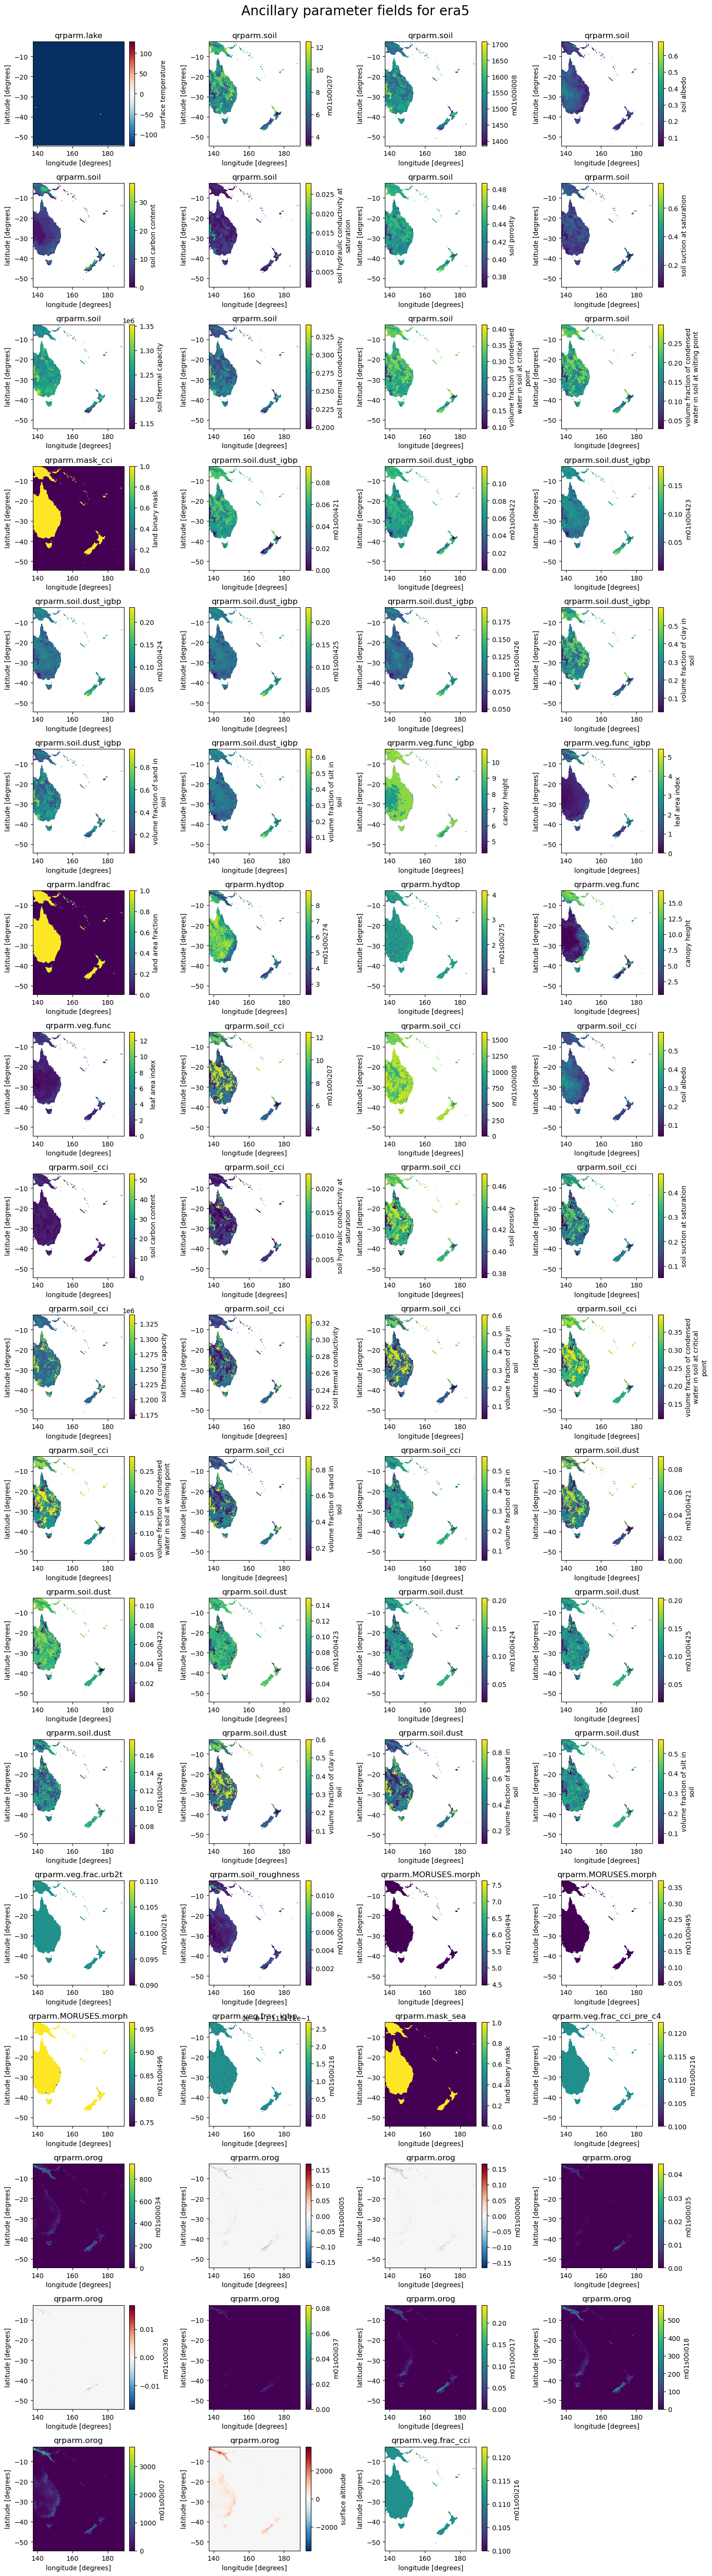

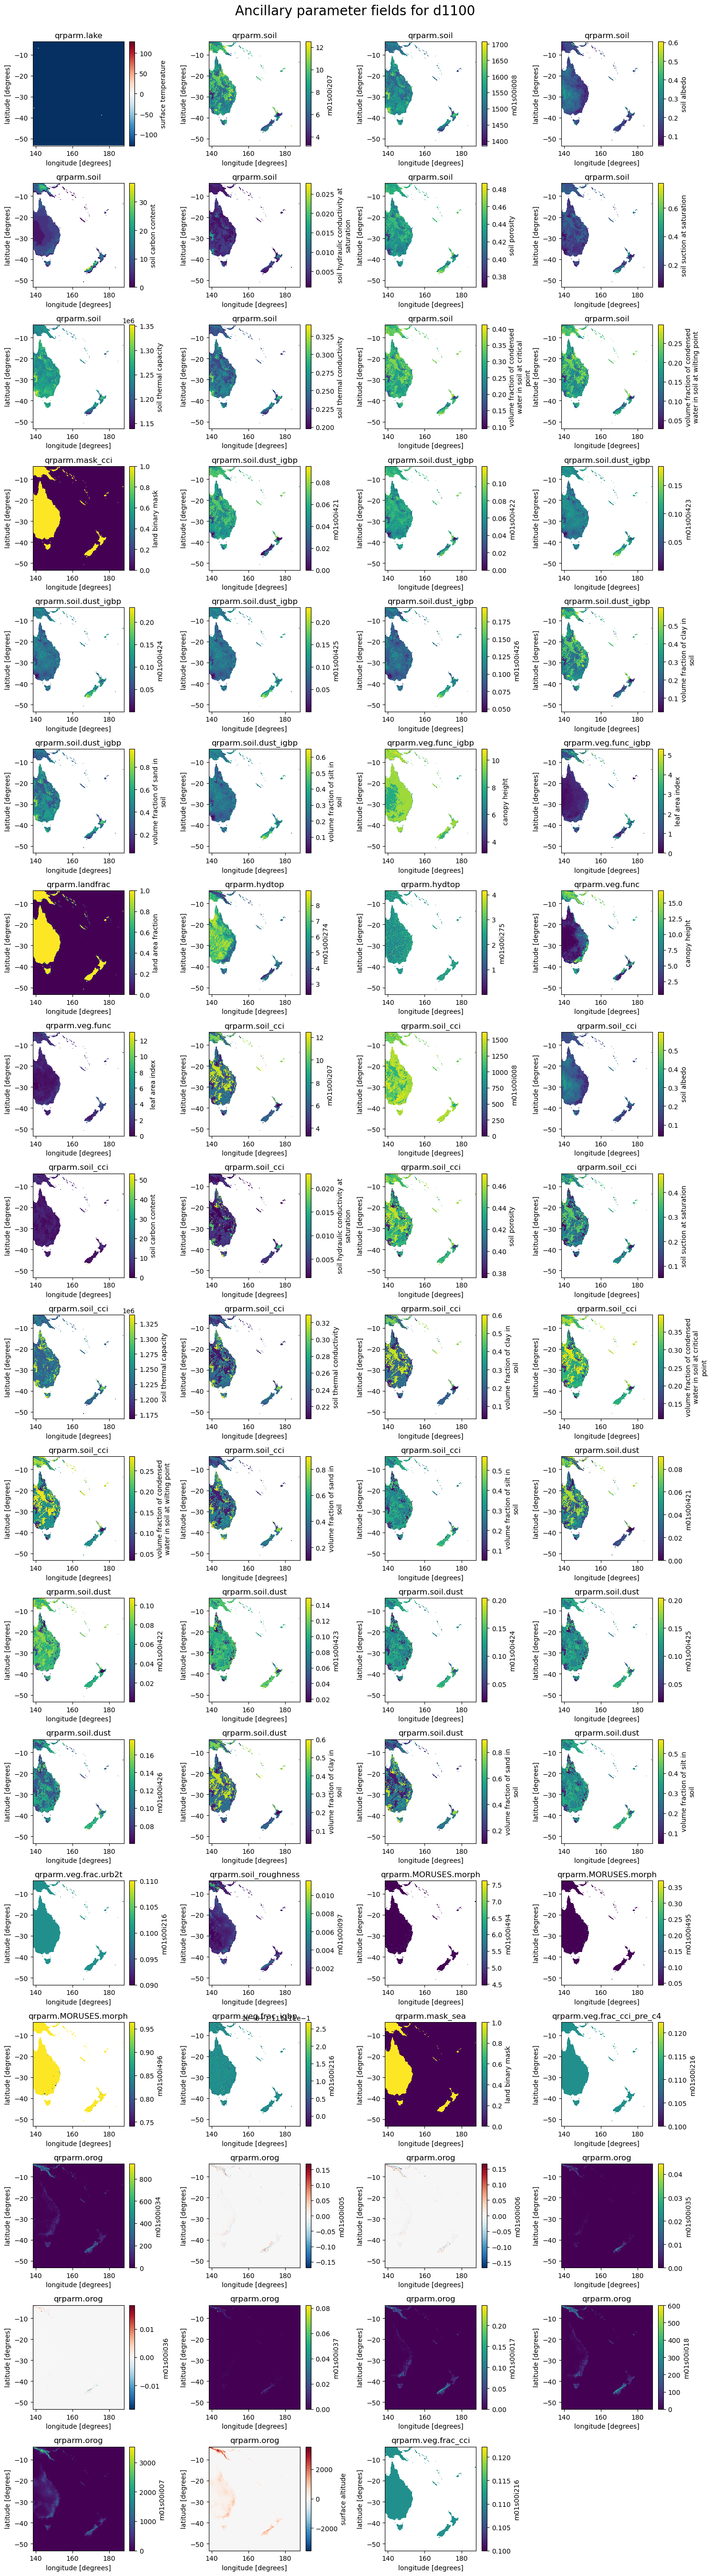

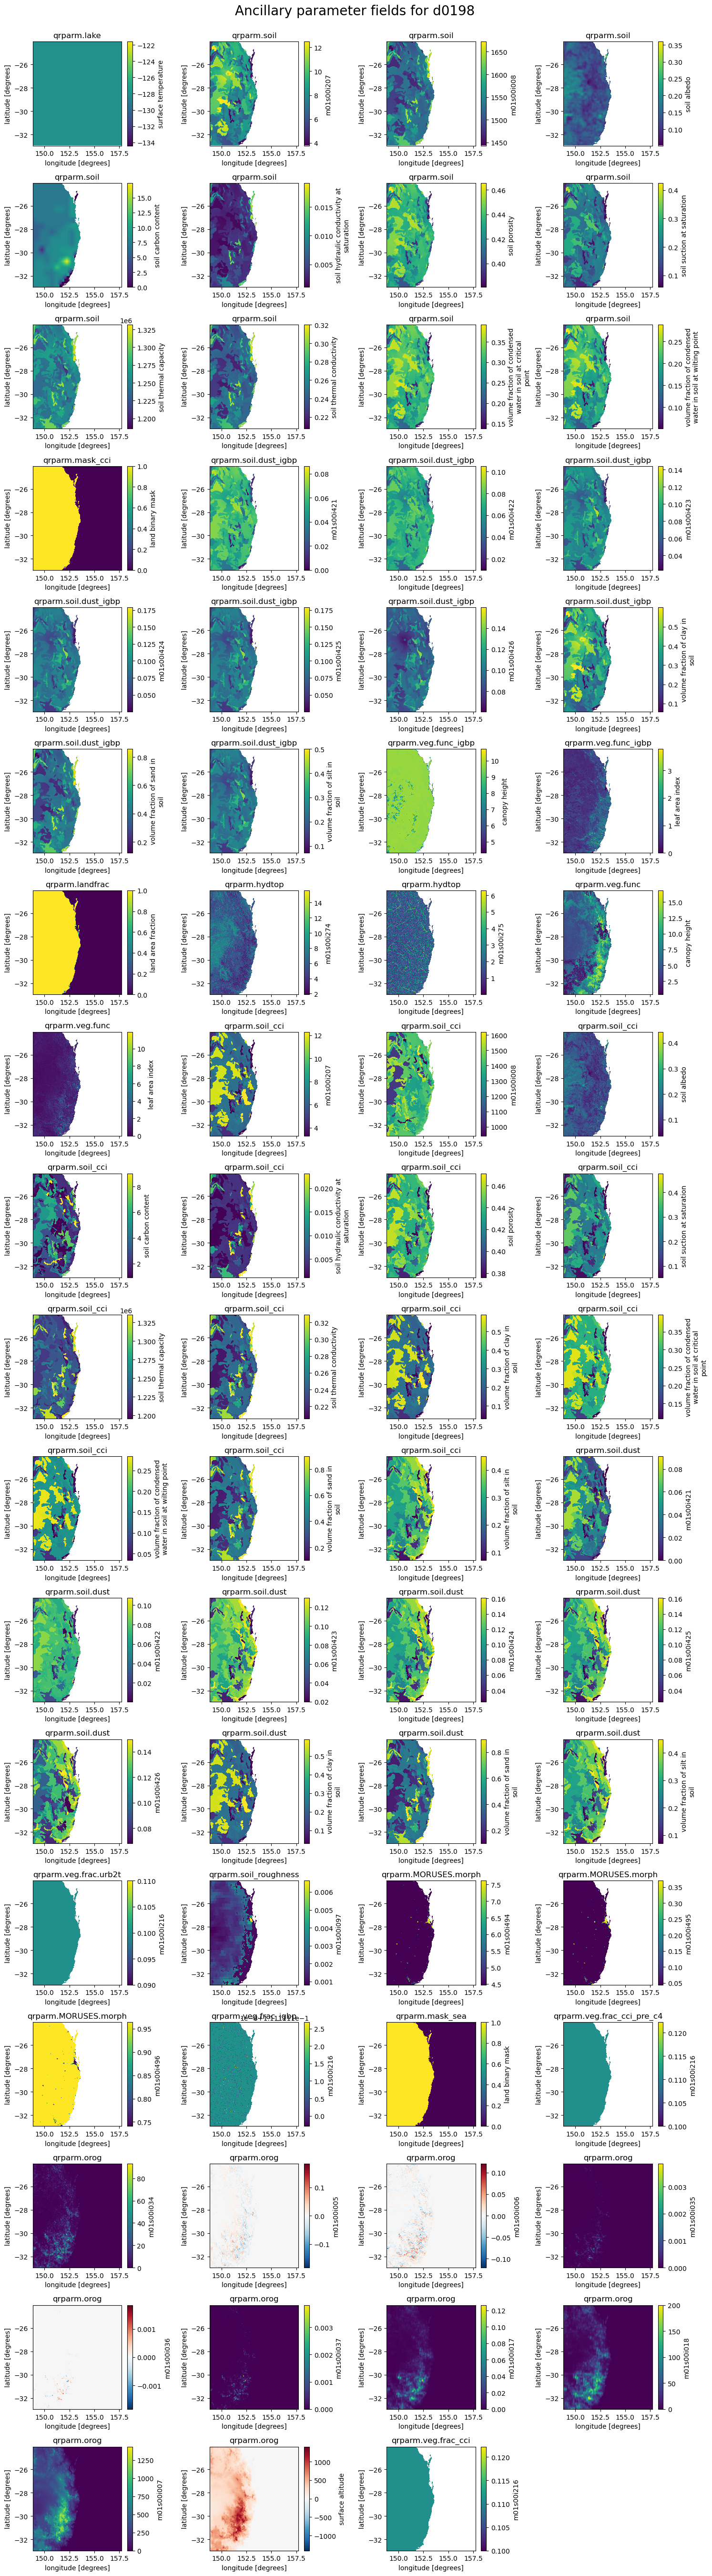

In [17]:
# Now plot for all resolutions and catch ancillary parameter fields with NaNs
bad_ancils = []

# Loop over all resolutions
for res in parm_files.keys():
#for res in ['test']:
    nan_ancils = plot_ancils(res,
                             parm_files[res],
                             num_plots[res])

    bad_ancils.extend(nan_ancils)
    

Do we have any ancillaries with NaNs?

Are there an bad ancillaries?

In [19]:
if len(bad_ancils) > 0:
    print (f'WARNING : Your ancillaries have some missing data over land!')
else:
    print (f'INFO : Your ancillaries appear to be okay over land')

INFO : Your ancillaries appear to be okay over land


If you have some bad ancillaries, use some of the following code to help find them. This code was used to find errors in canopy 
height near Macqaurie Island. You can edit the code below to try and zoom in on your particular region of interest

In [21]:
# Zoom in on NaNs. Let's do this manually for region era5
# These ancils have a land-sea mask so we need to extract that
if len(bad_ancils) > 0:
    da = bad_ancils[0]
    mask = lsm_masks['era5']
    
    all_mask = mask & da.isnull()
    
    # Find location of NaNs
    all_mask.compute()
    all_mask.where(all_mask.compute()==True,drop=True).compute()

In [18]:
# Now plot the bad_ancils
num_plot=len(bad_ancils)
num_columns=3
num_rows = num_plot // num_columns

if num_plot % num_columns != 0:
    num_rows += 1

Position = range(1,num_plot+1)

fig_height = num_rows*3
fig_width = 15
max_label_length=30

fig = plt.figure(figsize=(fig_width,fig_height))

k = 0

for k in range(num_plot):
     ax = fig.add_subplot(num_rows, num_columns, Position[k])
     da = bad_ancils[k]
     da.plot(ax=ax)
     ax.set_title(f'{da.name}')
plt.tight_layout()

<Figure size 1500x0 with 0 Axes>

In [ ]:
# OK, so we seem to have three points of NaN located b/w lat -54.7 to -52.6
# lat 158.9 to 169.2
da.sel(latitude=slice(-55,-45),longitude=slice(158,170)).plot()


In [ ]:
# So we are in the Southern Ocean. Let's plot the bad points
points = all_mask.where(all_mask.compute()==True,drop=True).compute()

In [ ]:
all_mask.sel(latitude=slice(-55,-45),longitude=slice(158,170)).plot()

In [ ]:
# These points appear to be associated with Macquarie Island and Campbell Island.
# Let's plot all the ERA5 ancillaries around Macquarie Island.
all_mask.sel(latitude=slice(-55,-54),longitude=slice(158,159)).plot()

In [ ]:
res='era5'
nan_ancils = plot_ancils(res,
                         parm_files[res],
                         num_plots[res],
                         lat_range=[-55,-54],
                         lon_range=[158,159])

In [ ]:
# Repeat for Cambpell Island
all_mask.sel(latitude=slice(-53,-52),longitude=slice(168.5,169.5)).plot()

In [ ]:
res='era5'
nan_ancils = plot_ancils(res,
                         parm_files[res],
                         num_plots[res],
                         lat_range=[-53,-52],
                         lon_range=[168.5,169.5])

In [ ]:
# Same issue for Macquarie Island - the canopy height fields are missing

In [ ]:
# OK. So Macquarie Island is resolved at this resolution for all ancillaries except canopy height.
#  And the island is resolved by qrparm.mask_cci (which is the file used by the UM).
#  The island isn't resolved by qrparm.mask_sea however.
# Let's use the method suggested by Matthew Lipson : https://forum.access-hive.org.au/t/aus2200-vegetation-fraction-ancil-creation-issues/1972/13?u=paul.gregory
veg_func_file, = [ f for f in parm_files['era5'] if f.name == 'qrparm.veg.func' ]
lsm_mask_file,  = [ f for f in parm_files['era5'] if f.name == 'qrparm.mask_cci' ]

In [ ]:
veg_cube = ants.load(veg_func_file)[0]
lsm_cube = ants.load(lsm_mask_file)[0]

In [ ]:
level=3
canopy_level = iris.Constraint(pseudo_level=level)

In [ ]:
veg_cube.extract(canopy_level)

In [ ]:
veg_cube.coords()

In [ ]:
# Use time constraints
# https://gist.github.com/dennissergeev/58a04be5fdfe37cedea838a19203e75e
tcoord = veg_cube.coord("time")
time_constr = iris.Constraint(time=lambda t: t.point == tcoord.units.num2date(tcoord.points[0]))
veg_slice=veg_cube.extract(time_constr).extract(canopy_level)

In [ ]:
veg_slice

In [ ]:
# Plot veg_slice around the southern ocean:
fig=plt.figure()
iris.plot.pcolormesh(veg_slice.intersection(latitude=(-55,-45),longitude=(158,170)))
plt.colorbar()

In [ ]:
veg_cube.extract(canopy_level)

In [ ]:
canopy_height = xr.DataArray.from_iris(veg_cube)
canopy_height

In [ ]:
fig,ax=plt.subplots(5,1,figsize=(5,15))

for level in canopy_height.dim_0:
    da = canopy_height.sel(dim_0=level,latitude=slice(-55,-45),longitude=slice(158,170)).\
         mean('time').plot(ax=ax.flatten()[level])
plt.tight_layout()

In [ ]:
# To do - interrrogate the master data ancillary to see if the data is missing at these levels
master_lai = Path('/home/548/pag548/cylc-run/u-dg767/share/data/etc/ancil_master_cap/vegetation/lai/modis_4km/v1/qrparm.data')
master_lai_cube, = ants.load(master_lai)
tcoord = master_lai_cube.coord("time")
time_constr = iris.Constraint(time=lambda t: t.point == tcoord.units.num2date(tcoord.points[0]))

In [ ]:
master_lai_da = xr.DataArray.from_iris(master_lai_cube)
master_lai_da[0]

In [ ]:
master_lai_da[0].plot()

In [ ]:
master_lai_da[0].sel(latitude=slice(-55+180,-45+180),longitude=slice(158,170)).plot()

In [ ]:
master_canopy = Path('/home/548/pag548/cylc-run/u-dg767/share/data/etc/ancil_master_cap/vegetation/canopy/simard/v1/Simard_Pinto_3DGlobalVeg_JGR.nc')
master_canopy_cube, = ants.load(master_canopy)
master_canopy_cube

In [ ]:
master_cover = Path('/home/548/pag548/cylc-run/u-dg767/share/data/etc/ancil_master_cap/vegetation/cover/igbp/v3/gigbp2_0ll.nc')
master_cover_cube, = ants.load(master_cover)

In [ ]:
# Repeat of u-cp146